# Price Prediction

## Data Manipulation

In [7]:

# Data Manipulation
import pandas as pd
import math
from datetime import datetime

# Data Vizualization
import matplotlib.pyplot as plt

# Arima Model Building
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# LSTM Model Building
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


### Get Data

In [9]:
from init_all_data import init_all_required_data

init_all_required_data()


Getting S & P info
Done
getting current most active stocks
Done
Populating Db with most active stocks
Done
Getting Price Data and Populating Database


BRK.B: No timezone found, symbol may be delisted
BF.B: No price data found, symbol may be delisted (1d 1925-08-11 -> 2024-07-18)


Done


### Map Price to Ticker

In [7]:
import os
from get_stock_data import get_all_price_data_mapped_to_ticker

# os.chdir(os.path.dirname(os.path.abspath(__file__)))
map = get_all_price_data_mapped_to_ticker()

../../data/database/


### Replace index with date

In [9]:
for x in map:
    map[x]['Date'] = pd.to_datetime(map[x]['Date'])
    map[x].set_index("Date", inplace = True)    

    
    
# map["MMM"].iloc['2000-01-01':'2024-12-31']

### Create Day Difference (Make Stationary)


In [11]:
def create_diff(x):    
    map[x] = map[x][map[x]["Open"] != 0]

    map[x]["day_diff"] = map[x]["Open"].diff(-1)
    map[x].dropna(inplace = True)
    # map[x].index = pd.DatetimeIndex(map[x].index)
    return map[x]

In [13]:
create_diff("AAPL")

,Open,High,Low,Close,Volume,Dividends,Stock Splits,day_diff
Date,,,,,,,,
1980-12-12,0.099058,0.099488,0.099058,0.099058,469033600,0.0,0.0,0.004737
1980-12-15,0.094321,0.094321,0.093890,0.093890,175884800,0.0,0.0,0.006891
1980-12-16,0.087429,0.087429,0.086999,0.086999,105728000,0.0,0.0,-0.001723
1980-12-17,0.089152,0.089582,0.089152,0.089152,86441600,0.0,0.0,-0.002585
1980-12-18,0.091737,0.092167,0.091737,0.091737,73449600,0.0,0.0,-0.005599
...,...,...,...,...,...,...,...,...
2024-07-09,227.929993,229.399994,226.369995,228.679993,48076100,0.0,0.0,-1.370010
2024-07-10,229.300003,233.080002,229.250000,232.979996,62627700,0.0,0.0,-2.089996
2024-07-11,231.389999,232.389999,225.770004,227.570007,64710600,0.0,0.0,2.470001


# Arima Model 

## EDA

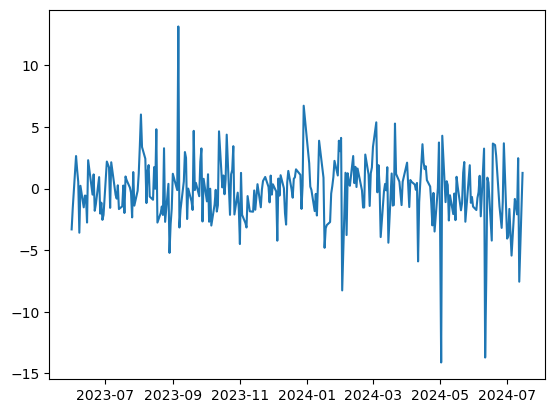

In [15]:
plt.plot((map["AAPL"].loc["6-1-23":"7-31-24"]["day_diff"]))


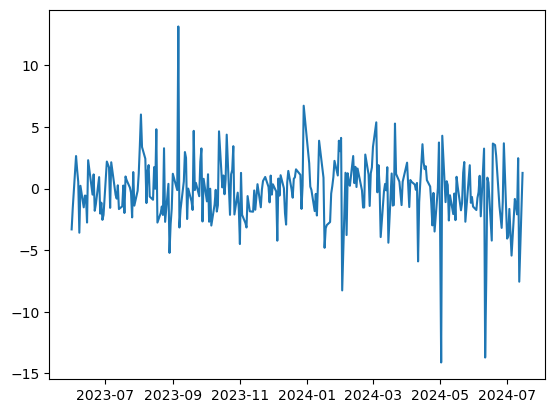

In [17]:
# map["MMM"]["day_diff"] = [math.log(x)for x in map["MMM"]["day_diff"]]
# plt.plot(math.log(map["MMM"].loc["1-1-22":"12-23-24"]["Open"]))
plt.plot((map["AAPL"].loc["6-1-23":"7-31-24"]["day_diff"]))

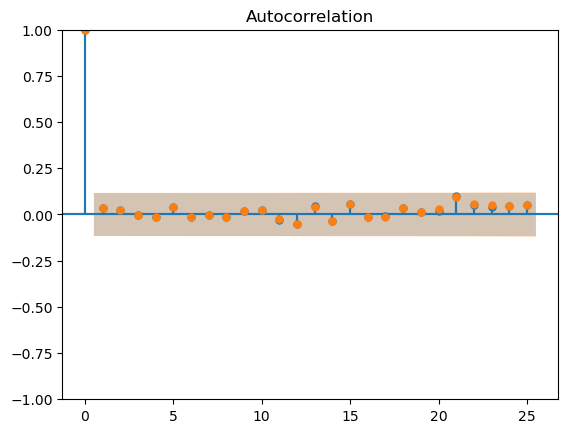

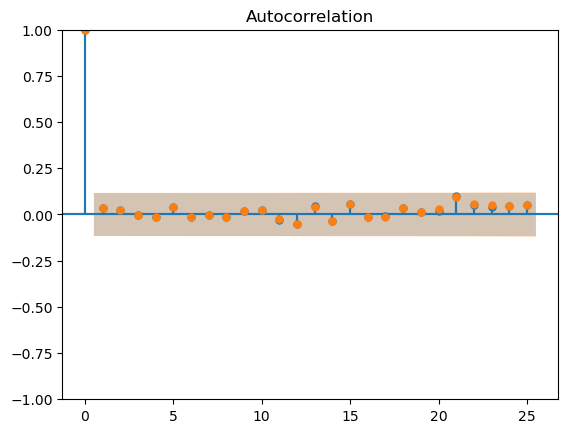

In [19]:
figure, ax = plt.subplots()

plot_pacf(map["AAPL"].loc["6-1-23":"7-31-24"]["day_diff"], ax = ax)
plot_acf(map["AAPL"].loc["6-1-23":"7-31-24"]["day_diff"], ax = ax)

# Model Building

## ARIMA Model(Not useable)

In [21]:
# def create_split(x):
#     global train_set 
#     global test_set
#     train_set = map[x].loc["1-2-24":"5-1-24"]["day_diff"]
#     test_set = map[x].loc["5-1-24":"7-16-24"]["day_diff"]
    


In [231]:
# create_split("MMM")
# train_set

1987   -1.210494e-03
1988   -4.845571e-03
1989   -1.090227e-02
1990   -6.056592e-03
1991   -1.453584e-02
            ...     
4995    3.417757e-03
4996   -2.050771e-02
4997    1.101819e-07
4998    1.367129e-02
4999    2.269130e-08
Name: day_diff, Length: 3013, dtype: float64

In [237]:
# model = ARIMA(map["MMM"]["day_diff"], order = (4,1,0))
# model_fit = model.fit()
# print(model_fit.summary())


# # forecast_test = model.fit(len())
# output = model_fit.forecast()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               day_diff   No. Observations:                13753
Model:                 ARIMA(4, 1, 0)   Log Likelihood              -16553.862
Date:                Tue, 16 Jul 2024   AIC                          33117.725
Time:                        18:54:33   BIC                          33155.370
Sample:                             0   HQIC                         33130.268
                              - 13753                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7913      0.003   -271.560      0.000      -0.797      -0.786
ar.L2         -0.5963      0.004   -166.042      0.000      -0.603      -0.589
ar.L3         -0.4044      0.004   -100.270      0.0

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


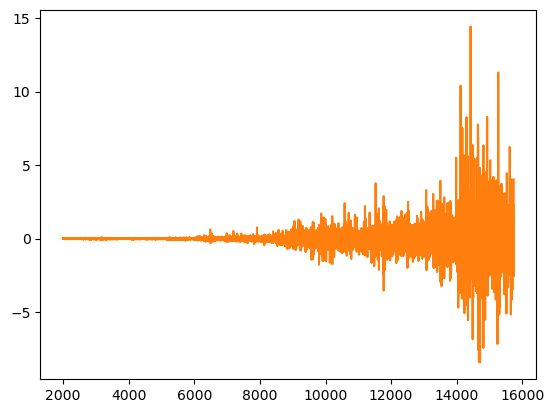

In [235]:
# figure, ax = plt.subplots(1) 
# ax.plot(output)
# ax.plot(map["MMM"]["day_diff"])


<Axes: >

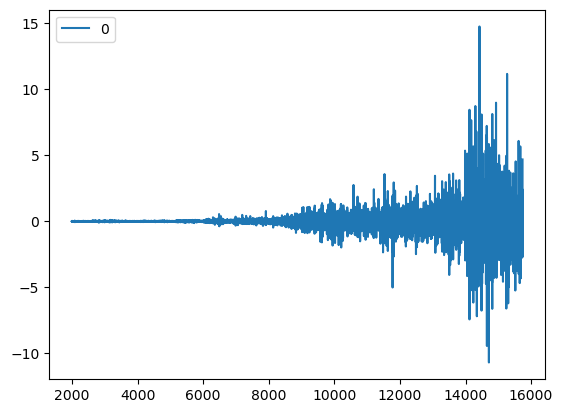

In [239]:
# residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()

# LSTM Model

In [439]:
days_back = 4

def get_range(df, start, end):
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)

    df = df.loc[start:end]
    
    # Univariate but will change to multivariate
    df = df[["Close"]]

    # Creates new columns
    for x in range(1, n + 1):            
        df[f"target - {x}"] = df["Close"].shift(x)

    
    
    
    # df["target - 1"] = df["Close"].shift(1)
    # df["target - 2"] = df["Close"].shift(2)
    # df["target - 3"] = df["Close"].shift(3)
    
    
    
    df.dropna(inplace = True)
     
    return df


def seperate_df(df):
    dates = df.index  
    X = df.iloc[:, 1:n + 1]
    Y = df["Close"]

    return dates, X, Y
    
    

### Set ticker and assign dfs

In [447]:


df = get_range(map["HD"], "1-1-2023", "12-31-2024")

dates, X, y = seperate_df(df)


X = X.to_numpy()
X = X.reshape(len(dates), X.shape[1], 1)



### Create train, validation, and test split

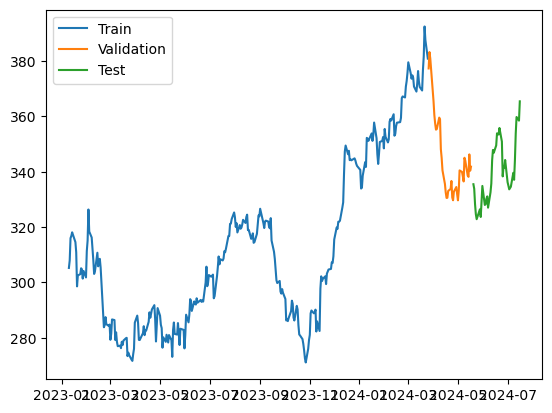

In [449]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

## Model Construction

In [5]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, validation_data=(X_val, y_val), batch_size=1, epochs=1)

# model = Sequential([layers.Input((n, 1)),
#                     layers.LSTM(64),
#                     layers.Dense(32, activation='relu'),
#                     layers.Dense(32, activation='relu'),
#                     layers.Dense(32, activation='relu'),
#                     layers.Dense(1)])

# model.compile(loss='mse', 
#               optimizer=Adam(learning_rate=0.001),
#               metrics=['mean_absolute_error'])

# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200)

2024-07-18 16:43:38.914968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'LSTM' is not defined

### Plot train data to prediction

10/10 [==============================] - 0s 1ms/step


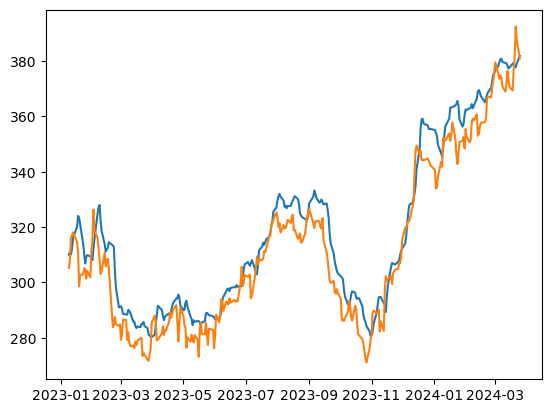

In [485]:
train_predictions = model.predict(X_train).flatten()


plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)



### Plot validation data to prediction

2/2 [==============================] - 0s 2ms/step


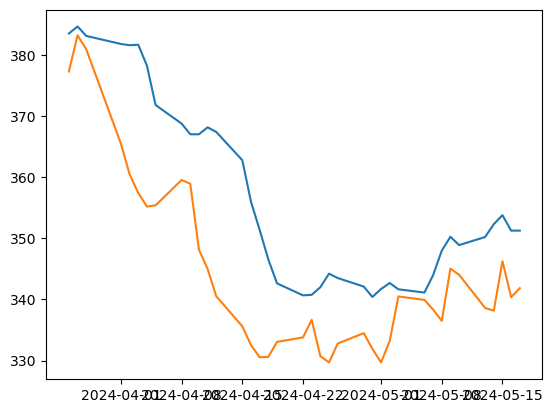

In [487]:
val_predictions = model.predict(X_val)


plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)


### Plot test data to prediction

2/2 [==============================] - 0s 3ms/step


/var/folders/7h/cf0mbd0943b18kq32zz405lr0000gn/T/ipykernel_58668/2282431865.py:6: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend("test", "prediction")


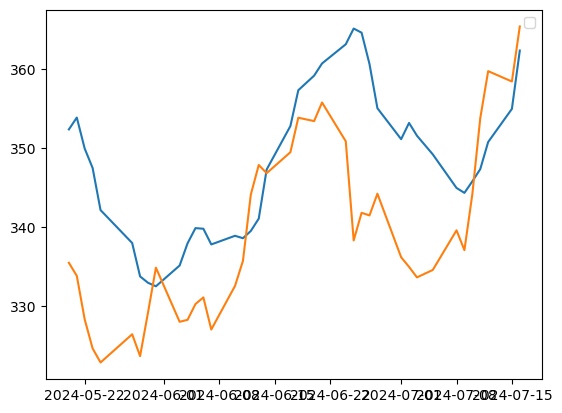

In [489]:
test_predictions = model.predict(X_test)


plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend("test", "prediction")

## Combined plots

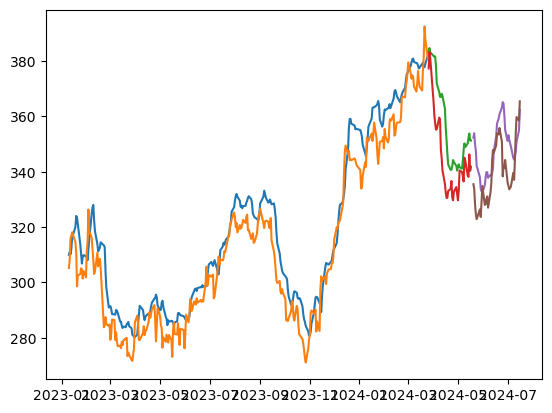

In [491]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)